In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm

import sys
sys.path.append("/n/home11/sambt/phlab-neurips25")
from models.litmodels import SimCLRModel
from models.networks import CustomPretrainedResNet, MLP
from torchvision.transforms import v2
from torchvision.datasets import Imagenette
from utils.plotting import make_corner
from sklearn.metrics import roc_auc_score, top_k_accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
base = "/n/home11/sambt/phlab-neurips25/runs/imagenette_fineTuneSupSimCLR_withClassifier/lightning_logs/q1ue2iyf/"
ckpt = base+"checkpoints/epoch=49-step=500.ckpt"
model = SimCLRModel.load_from_checkpoint(ckpt).to(device)

# load fine-tuned model
base = "/n/home11/sambt/phlab-neurips25/runs/imagenette_fineTuneSupSimCLR_withClassifier_fineTuneNoiseShift/lightning_logs/a6v43a97/"
ckpt = base+"checkpoints/epoch=17-step=180.ckpt"
model_tuned = SimCLRModel.load_from_checkpoint(ckpt).to(device)

/n/home11/sambt/phlab-neurips25/models/networks.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("/n/holystore01/LABS/iaifi_lab/Lab/sambt/neurips25/

In [3]:
test_augment = v2.Compose([v2.PILToTensor(),
                            v2.Resize(256),
                            v2.CenterCrop(224),
                            v2.ToDtype(torch.float32,scale=True)
                            ])
val_dataset = Imagenette(root="/n/holystore01/LABS/iaifi_lab/Lab/sambt/neurips25/imagenette/",
                        split='val',
                        size='full',
                        download=False,
                        transform=test_augment)
val_loader = DataLoader(val_dataset,batch_size=512,shuffle=True,num_workers=4)
train_dataset = Imagenette(root="/n/holystore01/LABS/iaifi_lab/Lab/sambt/neurips25/imagenette/",
                        split='train',
                        size='full',
                        download=False,
                        transform=test_augment)
train_loader = DataLoader(train_dataset,batch_size=512,shuffle=True,num_workers=4)

label_dict = {}
for k,v in val_dataset.class_to_idx.items():
    label_dict[v] = k
class_labels = sorted(list(label_dict.keys()))
class_means = {l:torch.zeros_like(train_dataset[0][0]) for l in class_labels}
class_counts = {l:0 for l in class_labels}

In [4]:
train_embeds = []
train_projects = []
train_labels = []
train_preds = []

train_embeds_tuned = []
train_projects_tuned = []
train_labels_tuned = []
train_preds_tuned = []

val_embeds = []
val_projects = []
val_labels = []
val_preds = []

val_embeds_tuned = []
val_projects_tuned = []
val_labels_tuned = []
val_preds_tuned = []

for batch in tqdm(train_loader):
    x,lab = batch
    
    for l in class_labels:
        nl = torch.count_nonzero(lab==l)
        if nl == 0: continue
        class_means[l] += x[lab==l].sum(dim=0)
        class_counts[l] += nl
    
    with torch.no_grad():
        h = model.encoder(x.to(device))
        train_embeds.append(h.cpu().numpy())
        z = model.projector(h)
        train_projects.append(z.cpu().numpy())
        if 'classifier' in dir(model):
            train_preds.append(model.classifier(h).cpu().numpy())
            
    with torch.no_grad():
        h = model_tuned.encoder(x.to(device))
        train_embeds_tuned.append(h.cpu().numpy())
        z = model_tuned.projector(h)
        train_projects_tuned.append(z.cpu().numpy())
        if 'classifier' in dir(model_tuned):
            train_preds_tuned.append(model_tuned.classifier(h).cpu().numpy())
            
    train_labels.append(lab.numpy())
    train_labels_tuned.append(lab.numpy())
for l in class_labels:
    class_means[l] = class_means[l] / class_counts[l]
    
for batch in tqdm(val_loader):
    x,lab = batch
    with torch.no_grad():
        h = model.encoder(x.to(device))
        val_embeds.append(h.cpu().numpy())
        z = model.projector(h)
        val_projects.append(z.cpu().numpy())
        if 'classifier' in dir(model):
            val_preds.append(model.classifier(h).cpu().numpy())
            
    with torch.no_grad():
        h = model_tuned.encoder(x.to(device))
        val_embeds_tuned.append(h.cpu().numpy())
        z = model_tuned.projector(h)
        val_projects_tuned.append(z.cpu().numpy())
        if 'classifier' in dir(model_tuned):
            val_preds_tuned.append(model_tuned.classifier(h).cpu().numpy())
    
    val_labels.append(lab.numpy())
    val_labels_tuned.append(lab.numpy())
    
train_embeds = np.concatenate(train_embeds,axis=0)
train_projects = np.concatenate(train_projects,axis=0)
train_labels = np.concatenate(train_labels,axis=0)
train_preds = np.concatenate(train_preds,axis=0)

train_embeds_tuned = np.concatenate(train_embeds_tuned,axis=0)
train_projects_tuned = np.concatenate(train_projects_tuned,axis=0)
train_labels_tuned = np.concatenate(train_labels_tuned,axis=0)
train_preds_tuned = np.concatenate(train_preds_tuned,axis=0)
    
val_embeds = np.concatenate(val_embeds,axis=0)
val_projects = np.concatenate(val_projects,axis=0)
val_labels = np.concatenate(val_labels,axis=0)
val_preds = np.concatenate(val_preds,axis=0)

val_embeds_tuned = np.concatenate(val_embeds_tuned,axis=0)
val_projects_tuned = np.concatenate(val_projects_tuned,axis=0)
val_labels_tuned = np.concatenate(val_labels_tuned,axis=0)
val_preds_tuned = np.concatenate(val_preds_tuned,axis=0)

100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


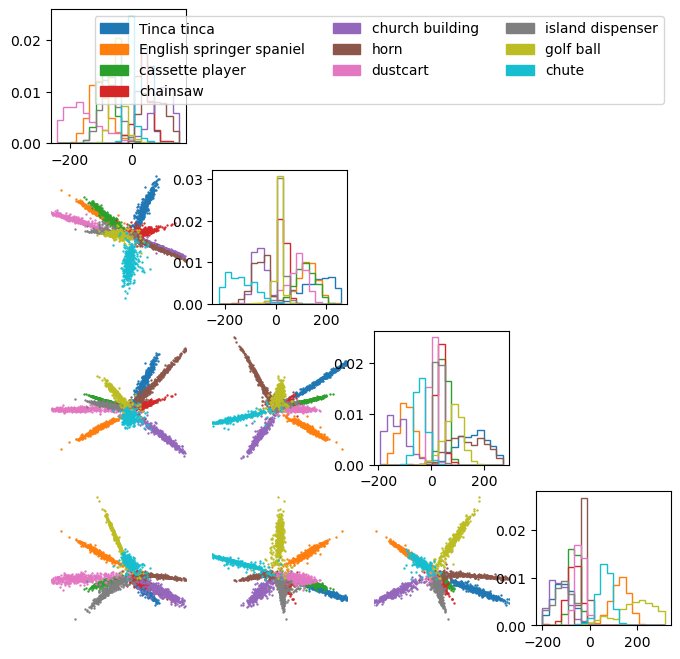

In [5]:
make_corner(val_embeds,val_labels,label_dict)

In [6]:
if 'classifier' in dir(model):
    auc = roc_auc_score(F.one_hot(torch.tensor(val_labels)).numpy(),val_preds)
    print("auc = ",auc)
    for k in range(1,6):
        topk = top_k_accuracy_score(val_labels,val_preds,k=k)
        print(f"Top {k} acc = ",topk)

auc =  0.9658172683632384
Top 1 acc =  0.9625477707006369
Top 2 acc =  0.9803821656050955
Top 3 acc =  0.9867515923566879
Top 4 acc =  0.9887898089171975
Top 5 acc =  0.990828025477707


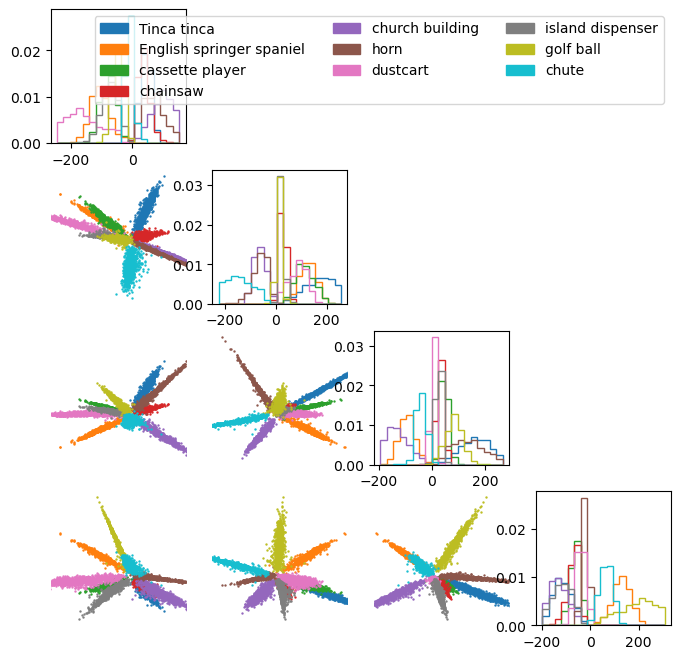

In [18]:
make_corner(train_embeds,train_labels,label_dict)

In [7]:
# "domain shift" test - evaluated classifier on "shifted" validation set
# shift operation is adding gaussian noise

val_embeds_shift = []
val_projects_shift = []
val_preds_shift = []
val_labels_shift = []

val_embeds_shift_tuned = []
val_projects_shift_tuned = []
val_preds_shift_tuned = []
val_labels_shift_tuned = []

eps_noise = 0.2
noiser = v2.GaussianNoise(sigma=eps_noise)

for batch in tqdm(val_loader):
    x,lab = batch
    x = noiser(x)
    with torch.no_grad():
        h = model.encoder(x.to(device))
        val_embeds_shift.append(h.cpu().numpy())
        z = model.projector(h)
        val_projects_shift.append(z.cpu().numpy())
        if 'classifier' in dir(model):
            val_preds_shift.append(model.classifier(h).cpu().numpy())
            
    with torch.no_grad():
        h = model_tuned.encoder(x.to(device))
        val_embeds_shift_tuned.append(h.cpu().numpy())
        z = model_tuned.projector(h)
        val_projects_shift_tuned.append(z.cpu().numpy())
        if 'classifier' in dir(model_tuned):
            val_preds_shift_tuned.append(model_tuned.classifier(h).cpu().numpy())
    
    val_labels_shift.append(lab.numpy())
    val_labels_shift_tuned.append(lab.numpy())

val_embeds_shift = np.concatenate(val_embeds_shift,axis=0)
val_projects_shift = np.concatenate(val_projects_shift,axis=0)
val_labels_shift = np.concatenate(val_labels_shift,axis=0)
val_preds_shift = np.concatenate(val_preds_shift,axis=0)
val_probs_shift = F.softmax(torch.tensor(val_preds_shift),dim=1).numpy()

val_embeds_shift_tuned = np.concatenate(val_embeds_shift_tuned,axis=0)
val_projects_shift_tuned = np.concatenate(val_projects_shift_tuned,axis=0)
val_labels_shift_tuned = np.concatenate(val_labels_shift_tuned,axis=0)
val_preds_shift_tuned = np.concatenate(val_preds_shift_tuned,axis=0)
val_probs_shift_tuned = F.softmax(torch.tensor(val_preds_shift_tuned),dim=1).numpy()

100%|██████████| 8/8 [00:14<00:00,  1.86s/it]


In [8]:
if 'classifier' in dir(model):
    auc = roc_auc_score(F.one_hot(torch.tensor(val_labels_shift)).numpy(),val_preds_shift)
    print("auc = ",auc)
    for k in range(1,6):
        topk = top_k_accuracy_score(val_labels_shift,val_preds_shift,k=k)
        print(f"Top {k} acc = ",topk)

auc =  0.9324915509401155
Top 1 acc =  0.8751592356687898
Top 2 acc =  0.9217834394904458
Top 3 acc =  0.9462420382165605
Top 4 acc =  0.9587261146496815
Top 5 acc =  0.9684076433121019


In [9]:
if 'classifier' in dir(model_tuned):
    auc = roc_auc_score(F.one_hot(torch.tensor(val_labels_shift_tuned)).numpy(),val_preds_shift_tuned)
    print("auc = ",auc)
    for k in range(1,6):
        topk = top_k_accuracy_score(val_labels_shift_tuned,val_preds_shift_tuned,k=k)
        print(f"Top {k} acc = ",topk)

auc =  0.9476117234154294
Top 1 acc =  0.9031847133757962
Top 2 acc =  0.9462420382165605
Top 3 acc =  0.9625477707006369
Top 4 acc =  0.9707006369426752
Top 5 acc =  0.9778343949044586


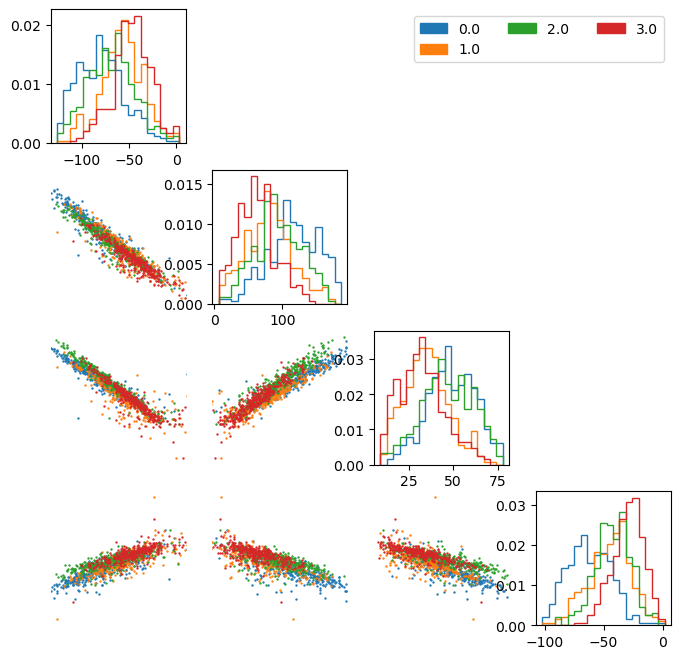

In [12]:
label_test = 2
test = val_embeds[val_labels==label_test]
test_tuned = val_embeds_tuned[val_labels_tuned==label_test]
test_shift = val_embeds_shift[val_labels_shift==label_test]
test_shift_tuned = val_embeds_shift_tuned[val_labels_shift_tuned==label_test]
make_corner(np.concatenate([test,test_shift,test_tuned,test_shift_tuned],axis=0),np.concatenate([np.zeros(len(test)),np.ones(len(test_shift)),2*np.ones(len(test_tuned)),3*np.ones(len(test_shift_tuned))]))

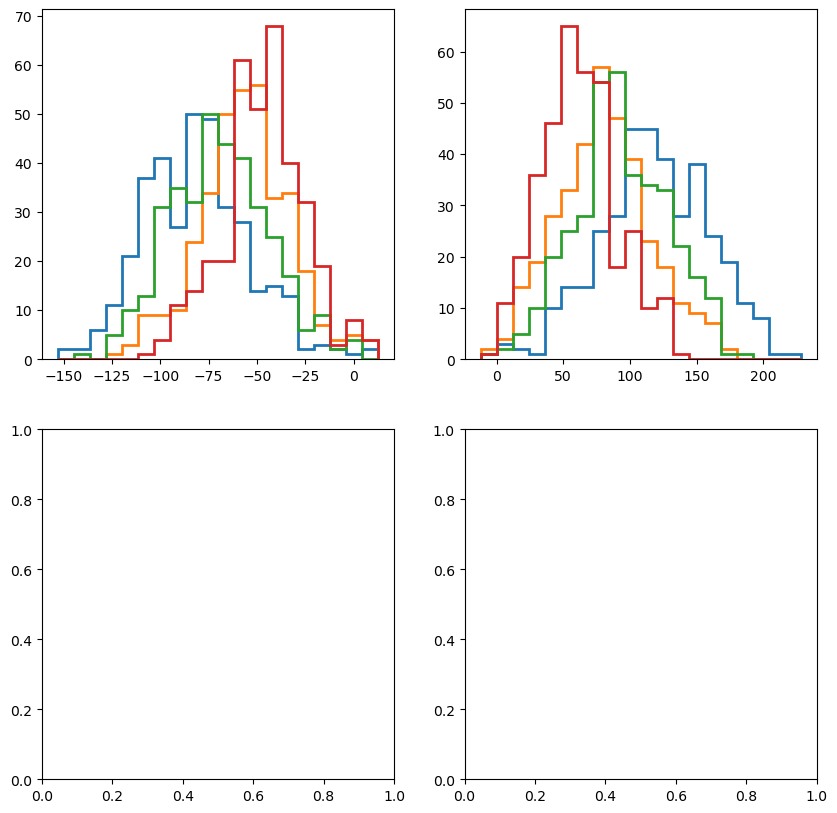

In [17]:
label_test = 2
test = val_embeds[val_labels==label_test]
test_tuned = val_embeds_tuned[val_labels_tuned==label_test]
test_shift = val_embeds_shift[val_labels_shift==label_test]
test_shift_tuned = val_embeds_shift_tuned[val_labels_shift_tuned==label_test]

fig,axes = plt.subplots(2,2,figsize=(10,10))

plt.sca(axes[0,0])
h,bins,_ = plt.hist(test[:,0],lw=2,color="C0",bins=20,histtype='step')
h = plt.hist(test_shift[:,0],lw=2,color="C1",bins=bins,histtype='step')
h = plt.hist(test_tuned[:,0],lw=2,color="C2",bins=bins,histtype='step')
h = plt.hist(test_shift_tuned[:,0],lw=2,color="C3",bins=bins,histtype='step')

plt.sca(axes[0,1])
h,bins,_ = plt.hist(test[:,1],lw=2,color="C0",bins=20,histtype='step')
h = plt.hist(test_shift[:,1],lw=2,color="C1",bins=bins,histtype='step')
h = plt.hist(test_tuned[:,1],lw=2,color="C2",bins=bins,histtype='step')
h = plt.hist(test_shift_tuned[:,1],lw=2,color="C3",bins=bins,histtype='step')